In [1]:
# https://www.datacamp.com/tutorial/fuzzy-string-python
# https://towardsdatascience.com/fuzzy-string-matching-in-python-68f240d910fe#:~:text=Fuzzywuzzy%20is%20a%20python%20library,showcase%20them%20on%20one%20platform.


In [1]:
# !pip install wandb
# !pip install transformers
# !pip install sentencepiece

from transformers import T5TokenizerFast, T5ForConditionalGeneration 
from transformers import Trainer

import os
import time 

os.environ["CUDA_VISIBLE_DEVICES"] = "2,3" 
import pandas as pd
import numpy as np
import torch
import torchvision
import Levenshtein
from fuzzywuzzy import fuzz
from datasets import list_metrics
from sklearn.metrics import precision_recall_fscore_support

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# wandb.login()

# os.environ["WANDB_DISABLED"] = "true"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Create torch dataset
# https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels['input_ids'][idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [3]:
# conellpp_test.to_csv('./1-NER_Data/1-csv_format/test/conell_test_data.csv', index = False)
# wikineural_test.to_csv('./1-NER_Data/1-csv_format/test/wiki_neural_test_data.csv', index = False)
# onto_test.to_csv('./1-NER_Data/1-csv_format/test/onto_test_data.csv', index = False)
# wnut_test.to_csv('./1-NER_Data/1-csv_format/test/wnut_test_data.csv', index = False)

In [4]:
def read_test_data(path):
    return pd.read_csv(path)

In [5]:
def encode_input_as_tokens(dataset):
    tokens = []
    for text in dataset["input_text"]:
        tokens.append(tokenizer('ner: ' + text, return_tensors="pt", padding=True, truncation=True, max_length=512).input_ids)
    return tokens

In [6]:
def predict_ner(model, tokens):
    results = []
    model = model.to(device)
    counter =0
    for token in tokens:
        results.append(model.generate(token.to(device))) 
        counter +=1
        if counter % 100==0:
            print(counter)
    return results

In [7]:
def decode_prediction(predicted_tokens):
    final_ouput_2 = []
    for result in predicted_tokens:
        final_ouput_2.append(tokenizer.decode(result[0], skip_special_tokens=True))
    return final_ouput_2

In [8]:
def compare_prediction_with_target(predictions, target_text):
    counter = 0
    for i in range(len(predictions)):
        if predictions[i] != target_text[i]:
            counter += 1
    return 1- counter/len(predictions)

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [10]:
max_source_length = 512
max_target_length = 512

In [11]:
tokenizer = T5TokenizerFast.from_pretrained("t5-base")
model_path = "./NER_normal_with_pos_v3/checkpoint-30940"
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)

In [ ]:
# from transformers import Seq2SeqTrainingArguments

# test_args = Seq2SeqTrainingArguments(
#     "test_trainer",
#     per_device_train_batch_size = 8,
#     per_device_eval_batch_size = 8,
#     eval_accumulation_steps = 50,  # VIP
#     predict_with_generate=True
# )

In [ ]:
# from transformers import Seq2SeqTrainer

# trainer = Seq2SeqTrainer(
#     model=model, 
#     args=test_args
# #     train_dataset= train_dataset, 
# #     eval_dataset= eval_dataset
# )

## conell test data 

In [12]:
conell_test_data = read_test_data('./1-NER_Data/1-csv_format/test/conell_test_data_with_pos.csv')
conell_test_data

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI...","*s* JAPAN | LOC *e* , *s* CHINA | LOC *e*",9,2,0.2
1,Nadim Ladki,*s* Nadim Ladki | PER *e*,2,2,1.0
2,"AL-AIN , United Arab Emirates 1996-12-06","*s* AL-AIN | LOC *e* , *s* United Arab Emirate...",5,4,0.8
3,Japan began the defence of their Asian Cup tit...,"*s* Japan | LOC *e* , *s* Asian Cup | MISC *e*...",24,4,0.2
4,But China saw their luck desert them in the se...,"*s* China | LOC *e* , *s* Uzbekistan | LOC *e*",23,2,0.1
...,...,...,...,...,...
3444,It all culminated in the fact that I now have ...,*s* Ireland | LOC *e*,17,1,0.1
3445,That is why this is so emotional a night for m...,*s* Charlton | PER *e*,13,1,0.1
3446,""" It was the joy that we all had over the peri...",*s**e*,27,0,0.0
3447,"Charlton managed Ireland for 93 matches , duri...","*s* Charlton | PER *e* , *s* Ireland | LOC *e*",24,2,0.1


<AxesSubplot:>

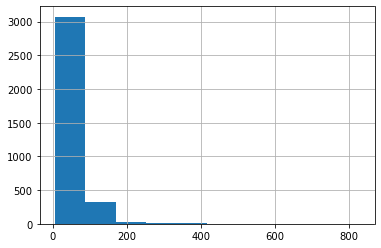

In [13]:
conell_test_data['target_text'].str.len().hist()

In [14]:
conell_tokens = encode_input_as_tokens(conell_test_data)

In [15]:
len(conell_tokens)

3449

In [16]:
start = time.time()
counter = 0
conell_pred = []
for token in conell_tokens:
    if counter%200 == 0:
        print(counter)
    counter += 1
    prediction = model.generate(token.to(device))
    conell_pred.append(prediction)
    
print(time.time() - start)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
878.4043989181519


In [ ]:
# conell_pred = predict_ner(model, conell_tokens)

In [17]:
conell_pred_decoded = decode_prediction(conell_pred)

In [18]:
conell_target_text = conell_test_data['target_text']

In [28]:
conell_target_text[4]

'*s* China | LOC *e* , *s* Uzbekistan | LOC *e*'

In [29]:
conell_pred_decoded[4]

'*s* China | LOC *e*, *s* Uzbeki'

In [19]:
conell_accuracy = compare_prediction_with_target(conell_pred_decoded, conell_target_text)
conell_accuracy

0.5091330820527689

In [98]:
all_predictions = []
all_targets = []
for i in range(len(conell_pred_decoded)):
    prediction = []
    target = []
#     print(conell_pred_decoded[i].split('*e*'))
    for part in conell_pred_decoded[i].split(','):
        if '*e*' not in part:
            continue
        prediction.append(part.strip())
    
    for part in conell_target_text[i].split(','):
        if '*e*' not in part:
            continue
        target.append(part.strip())
    
    all_predictions.append(prediction)
            
    all_targets.append(target)

In [99]:
all_targets

[['*s* JAPAN | LOC *e*', '*s* CHINA | LOC *e*'],
 ['*s* Nadim Ladki | PER *e*'],
 ['*s* AL-AIN | LOC *e*', '*s* United Arab Emirates | LOC *e*'],
 ['*s* Japan | LOC *e*', '*s* Asian Cup | MISC *e*', '*s* Syria | LOC *e*'],
 ['*s* China | LOC *e*', '*s* Uzbekistan | LOC *e*'],
 ['*s* China | LOC *e*',
  '*s* Uzbek | MISC *e*',
  '*s* Igor Shkvyrin | PER *e*',
  '*s* Chinese | MISC *e*'],
 ['*s* Oleg Shatskiku | PER *e*'],
 ['*s* Soviet | MISC *e*', '*s* Asian Cup | MISC *e*'],
 ['*s* Asian Games | MISC *e*', '*s* Uzbekistan | LOC *e*'],
 ['*s* Japan | LOC *e*', '*s* Syria | LOC *e*'],
 ['*s* Takuya Takagi | PER *e*',
  '*s* Hiroshige Yanagimoto | PER *e*',
  '*s* Syrian | MISC *e*',
  '*s* Salem Bitar | PER *e*'],
 ['*s* Syria | LOC *e*'],
 ['*s* Hassan Abbas | PER *e*', '*s* Bitar | PER *e*'],
 ['*s* Nader Jokhadar | PER *e*', '*s* Syria | LOC *e*'],
 ['*s* Japan | LOC *e*', '*s* Syrian | MISC *e*', '*s* Syrian | MISC *e*'],
 ['*s* Bitar | PER *e*'],
 ['*s* Japan | LOC *e*', '*s* Shu K

In [100]:
all_predictions

[['*s* JAPAN | LOC *e*'],
 ['*s* Nadim Ladki | PER *e*'],
 ['*s* AL-AIN | LOC *e*'],
 ['*s* Japan | LOC *e*'],
 ['*s* China | LOC *e*'],
 ['*s* China | LOC *e*'],
 ['*s* Oleg Shatskiku | PER *e*'],
 ['*s* Soviet | MISC *e*'],
 ['*s* Asian Games | MISC *e*'],
 ['*s* Japan | LOC *e*'],
 ['*s* Takuya Takagi | PER *e*'],
 ['*s* Syria | LOC *e*'],
 ['*s* Hassan Abbas | PER *e*'],
 ['*s* Nader Jokhadar | PER *e*'],
 ['*s* Japan | LOC *e*'],
 ['*s* Bitar | PER *e*'],
 ['*s* Japan | LOC *e*'],
 ['*s* Syrians | MISC *e*'],
 ['*s* Japan | LOC *e*'],
 ['*s* Hosts UAE | ORG *e*'],
 ['*s**e*'],
 ['*s* RUGBY UNION | ORG *e*'],
 ['*s* ROME | LOC *e*'],
 ['*s* Italy | LOC *e*'],
 ['*s* Scotland | LOC *e*'],
 ['*s* Cuttitta | PER *e*'],
 ['*s* Stefano Bordon | PER *e*'],
 ['*s* Cuttitta | PER *e*'],
 ['*s* Coste | PER *e*'],
 ['*s* World Cup | MISC *e*'],
 ['*s**e*'],
 ['*s**e*'],
 ['*s* Javier Pertile | PER *e*'],
 ['*s* JAPAN | LOC *e*'],
 ['*s* AL-AIN | LOC *e*'],
 ['*s* Japan | LOC *e*'],
 ['*s* Ta

In [101]:
# list(conell_target_text)

In [102]:
# all_predictions

In [103]:
# all_targets

In [118]:
counter_correct = 0
counter_FN = 0
counter_FP = 0
counter_all = 0

for i in range(len(all_predictions)):
    for target in all_targets[i]:
        counter_all += 1
        if target in all_predictions[i]:
            counter_correct += 1
            continue
        counter_FN += 1
    
    for pred in all_predictions[i]:    
        if pred not in all_targets[i]:
#             print(pred)
#             print(all_targets[i])
#             print()
            counter_FP += 1

In [114]:
counter_correct/(counter_correct + 0.5*(counter_FN + counter_FP))

0.6384537131230926

In [105]:
counter_correct = 0
counter_all = 0
for i in range(len(all_predictions)):
    counter_all += 1
    for target in all_targets[i]:
        
        if target in all_predictions[i]:
            counter_correct += 1
            break
            
counter_correct/counter_all        
# all_targets

0.9043200927805161

## wikineural test data

In [83]:
wiki_test_data = read_test_data('./1-NER_Data/1-csv_format/test/wiki_neural_test_data_with_pos.csv')
wiki_test_data

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,On this occasion he failed to gain the support...,*s* South Wales Miners ' Federation | ORG *e*,20,4,0.2
1,On both these occasions he was backed by the S...,*s* South Wales Miners ' Federation | ORG *e*,18,4,0.2
2,"He also appeared as himself in the 1996 film ""...",*s* Eddie | MISC *e*,10,1,0.1
3,The Colorado Rockies were created as an expans...,"*s* Colorado Rockies | ORG *e* , *s* Coors Fie...",17,4,0.2
4,He kept busy recording demo tapes at his home ...,"*s* La Valencia Hotel | LOC *e* , *s* La Jolla...",29,5,0.2
...,...,...,...,...,...
11592,"com , Amazon .",*s* Amazon | ORG *e*,2,1,0.5
11593,"In January 2013 , the European Food Safety Aut...","*s* European Food Safety Authority | ORG *e* ,...",27,5,0.2
11594,"All of the games had art true to the series , ...",*s* Sega | ORG *e*,23,1,0.0
11595,There was also a game made for the Game Boy ba...,*s* Game Boy | MISC *e*,20,2,0.1


In [84]:
wiki_tokens = encode_input_as_tokens(wiki_test_data)

In [85]:
len(wiki_tokens)

11597

In [86]:
wiki_pred = predict_ner(model, wiki_tokens)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500


In [87]:
wiki_pred_decoded = decode_prediction(wiki_pred)

In [88]:
wiki_target_text = wiki_test_data['target_text']

In [89]:
wiki_accuracy = compare_prediction_with_target(wiki_pred_decoded, wiki_target_text)
wiki_accuracy

0.5427265672156592

In [115]:
wiki_all_predictions = []
wiki_all_targets = []
for i in range(len(wiki_pred_decoded)):
    wiki_prediction = []
    wiki_target = []
#     print(conell_pred_decoded[i].split('*e*'))
    for part in wiki_pred_decoded[i].split(','):
        if '*e*' not in part:
            continue
        wiki_prediction.append(part.strip())
    
    for part in wiki_target_text[i].split(','):
        if '*e*' not in part:
            continue
        wiki_target.append(part.strip())
    
    wiki_all_predictions.append(wiki_prediction)
            
    wiki_all_targets.append(wiki_target)

In [117]:
wiki_counter_correct = 0
wiki_counter_FN = 0
wiki_counter_FP = 0
wiki_counter_all = 0

for i in range(len(wiki_all_predictions)):
    for target in wiki_all_targets[i]:
        wiki_counter_all += 1
        if target in wiki_all_predictions[i]:
            wiki_counter_correct += 1
            continue
        wiki_counter_FN += 1
    
    for pred in wiki_all_predictions[i]:    
        if pred not in wiki_all_targets[i]:
#             print(pred)
#             print(all_targets[i])
#             print()
            wiki_counter_FP += 1

In [120]:
wiki_counter_correct/(wiki_counter_correct + 0.5*(wiki_counter_FN + wiki_counter_FP))

0.6776182023559787

In [121]:
wiki_counter_correct = 0
wiki_counter_all = 0
for i in range(len(wiki_all_predictions)):
    wiki_counter_all += 1
    for target in wiki_all_targets[i]:
        
        if target in wiki_all_predictions[i]:
            wiki_counter_correct += 1
            break
            
wiki_counter_correct/wiki_counter_all        
# all_targets

0.8860912304906441

## onto test data

In [90]:
onto_test_data = read_test_data('./1-NER_Data/1-csv_format/test/onto_test_data_with_pos.csv')
onto_test_data

,input_text,target_text,word_count,NE_count,%_NE_in_sentence
0,The farmer Yang Zhifa and a neighbor were digg...,*s* Yang Zhifa | PER *e*,18,1,0.1
1,The waves were coming over the sides and into ...,*s**e*,18,0,0.0
2,and then next year it 'll be eleven thousand.,*s**e*,9,0,0.0
3,"Chinese society is male dominated, and women a...",*s* Chinese | MISC *e*,15,1,0.1
4,That's their response.,*s**e*,3,0,0.0
...,...,...,...,...,...
10455,"Many analysts expect Mr. Andersson, who owns 1...","*s* Trelleborg | ORG *e* , *s* Andersson | PER...",25,3,0.1
10456,And it's %uh %eh prayer,*s**e*,5,0,0.0
10457,"Michael Fisher, general manager of KTXL, a Fox...","*s* Sacramento | MISC *e* , *s* Calif. | MISC ...",24,6,0.2
10458,"The world does not know you, but I know you, a...",*s**e*,20,0,0.0


In [91]:
onto_tokens = encode_input_as_tokens(onto_test_data)

In [92]:
len(onto_tokens)

10460

In [93]:
onto_pred = predict_ner(model, onto_tokens)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400


In [94]:
onto_pred_decoded = decode_prediction(onto_pred)

In [95]:
onto_target_text = onto_test_data['target_text']

In [96]:
onto_accuracy = compare_prediction_with_target(onto_pred_decoded, onto_target_text)
onto_accuracy

0.5919694072657744

In [122]:
onto_all_predictions = []
onto_all_targets = []
for i in range(len(onto_pred_decoded)):
    onto_prediction = []
    onto_target = []
#     print(conell_pred_decoded[i].split('*e*'))
    for part in onto_pred_decoded[i].split(','):
        if '*e*' not in part:
            continue
        onto_prediction.append(part.strip())
    
    for part in onto_target_text[i].split(','):
        if '*e*' not in part:
            continue
        onto_target.append(part.strip())
    
    onto_all_predictions.append(onto_prediction)
            
    onto_all_targets.append(onto_target)

In [123]:
onto_counter_correct = 0
onto_counter_FN = 0
onto_counter_FP = 0
onto_counter_all = 0

for i in range(len(onto_all_predictions)):
    for target in onto_all_targets[i]:
        onto_counter_all += 1
        if target in onto_all_predictions[i]:
            onto_counter_correct += 1
            continue
        onto_counter_FN += 1
    
    for pred in onto_all_predictions[i]:    
        if pred not in onto_all_targets[i]:
#             print(pred)
#             print(all_targets[i])
#             print()
            onto_counter_FP += 1

In [124]:
onto_counter_correct/(onto_counter_correct + 0.5*(onto_counter_FN + onto_counter_FP))

0.7001619604253222

In [125]:
onto_counter_correct = 0
onto_counter_all = 0
for i in range(len(onto_all_predictions)):
    onto_counter_all += 1
    for target in onto_all_targets[i]:
        
        if target in onto_all_predictions[i]:
            onto_counter_correct += 1
            break
            
onto_counter_correct/onto_counter_all        
# all_targets

0.9280114722753346